In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
# https://datashare.ed.ac.uk/handle/10283/1942
# 위 링크에서 데이터를 다운받아 자신의 경로에 맞게 디렉토리를 만들고 데이터를 unzip한다
# 아래의 코드를 실행하기 전에 데이터가 
# !mkdir "./data/CleanData"
# !mkdir "./data/NoisyData/"
# !unzip "./clean_trainset_wav.zip" -d "./data/CleanData/data/CleanData"
# !unzip "./noisy_trainset_wav.zip" -d "./data/CleanData/data/NoisyData"

In [4]:
clean_sounds = glob.glob('./data/CleanData/*')
noisy_sounds = glob.glob('./data/NoisyData/*')


clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for i in tqdm(clean_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)


for i in tqdm(noisy_sounds[1:]):
  so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
  noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape,noisy_sounds_list.shape

  0%|          | 0/11571 [00:00<?, ?it/s]

  0%|          | 0/11571 [00:00<?, ?it/s]

(TensorShape([540938091, 1]), TensorShape([540938091, 1]))

In [5]:
batching_size = 12000

clean_train,noisy_train = [],[]

for i in tqdm(range(0, clean_sounds_list.shape[0]-batching_size, batching_size)):
  clean_train.append(clean_sounds_list[i:i+batching_size])
  noisy_train.append(noisy_sounds_list[i:i+batching_size])    
clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)
clean_train.shape,noisy_train.shape

  0%|          | 0/45078 [00:00<?, ?it/s]

(TensorShape([45078, 12000, 1]), TensorShape([45078, 12000, 1]))

In [11]:
def get_dataset(x_train, y_train):
  dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
  dataset = dataset.shuffle(100).batch(64, drop_remainder=True)
  return dataset

In [12]:
train_dataset = get_dataset(noisy_train[:40000], clean_train[:40000])
test_dataset = get_dataset(noisy_train[40000:], clean_train[40000:])

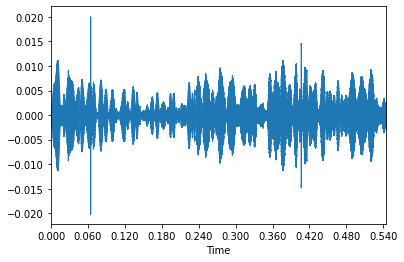

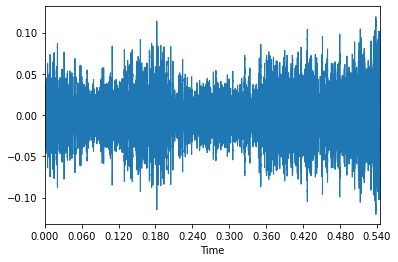

In [100]:
librosa.display.waveplot(np.squeeze(clean_train[3].numpy(),axis=-1))
plt.show()
librosa.display.waveplot(np.squeeze(noisy_train[3].numpy(),axis=-1))
plt.show()

In [98]:
inp = Input(shape=(batching_size,1))
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 6000, 2)      66          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 3000, 4)      260         conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 1500, 8)      1032        conv1d_6[0][0]                   
____________________________________________________________________________________________

In [17]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [166]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset,epochs=20)

Epoch 1/20
625/625 [==============================] - 400s 638ms/step - loss: 0.0119
Epoch 2/20
625/625 [==============================] - 424s 679ms/step - loss: 0.0119
Epoch 3/20
625/625 [==============================] - 428s 684ms/step - loss: 0.0124
Epoch 4/20
625/625 [==============================] - 443s 710ms/step - loss: 0.0120
Epoch 5/20
625/625 [==============================] - 367s 587ms/step - loss: 0.0119
Epoch 6/20
625/625 [==============================] - 2258s 4s/step - loss: 0.0118
Epoch 7/20
625/625 [==============================] - 6300s 10s/step - loss: 0.0118
Epoch 8/20
625/625 [==============================] - 379s 607ms/step - loss: 0.0117
Epoch 9/20
625/625 [==============================] - 338s 540ms/step - loss: 0.0117
Epoch 10/20
625/625 [==============================] - 2275s 4s/step - loss: 0.0118
Epoch 11/20
625/625 [==============================] - 342s 547ms/step - loss: 0.0117
Epoch 12/20
625/625 [==============================] - 336s 537ms/st

In [142]:
from IPython.display import Audio
Audio(np.squeeze(noisy_train[22].numpy()),rate=16000)

In [144]:
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[22],-1),0))),rate=16000)

In [145]:
model.evaluate(test_dataset)   

79/79 [==============================] - 15s 173ms/step - loss: 0.0120


0.011984503827989101

In [168]:
model.save('NoiseSuppressionModel2.h5')

In [167]:
def get_audio(path):
  audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
  return audio

In [169]:
def inference_preprocess(path):
  audio = get_audio(path)
  audio_len = audio.shape[0]
  batches = []
  for i in range(0,audio_len-batching_size,batching_size):
    batches.append(audio[i:i+batching_size])

  batches.append(audio[-batching_size:])
  diff = audio_len - (i + batching_size)
  return tf.stack(batches), diff

In [170]:
def predict(path):
  test_data,diff = inference_preprocess(path)
  predictions = model.predict(test_data)
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)
  return final_op

In [171]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [172]:
Audio(tf.squeeze(predict(noisy_sounds[4])),rate=16000)

In [39]:
%%timeit
tf.squeeze(predict(noisy_sounds[4]))

60.6 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


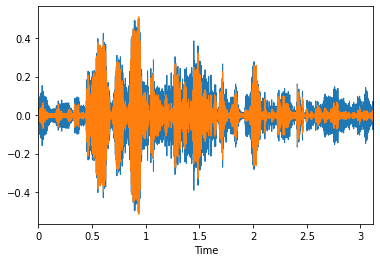

In [173]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[4])))

In [174]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

INFO:tensorflow:Assets written to: /var/folders/0y/4v1sgvj55hjflc2k_m2wy3hh0000gn/T/tmpu0zac05h/assets


INFO:tensorflow:Assets written to: /var/folders/0y/4v1sgvj55hjflc2k_m2wy3hh0000gn/T/tmpu0zac05h/assets


In [175]:
with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)

In [176]:
interpreter = tf.lite.Interpreter(model_path='./TFLiteModel.tflite')
interpreter.allocate_tensors()

In [177]:
def predict_tflite(path):
  test_audio,diff = inference_preprocess(path)
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  preds = []
  for i in test_audio:
    interpreter.set_tensor(input_index, tf.expand_dims(i,0))
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    preds.append(predictions)

  predictions = tf.squeeze(tf.stack(preds,axis=1))
  final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
  final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
  return final_op

In [158]:
%%timeit
predict_tflite(noisy_sounds[3])

104 ms ± 6.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [178]:
Audio(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1),rate=16000)

In [179]:
Audio(np.squeeze(get_audio(clean_sounds[4]).numpy(),-1),rate=16000)

In [180]:
Audio(predict_tflite(noisy_sounds[4]),rate=16000)

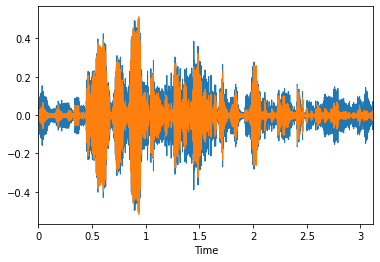

In [181]:
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[4]).numpy(),-1))
librosa.display.waveplot(predict_tflite(noisy_sounds[4]).numpy())

In [12]:
test_sounds = glob.glob('./data/testData/*.wav')

# predict sounds
Audio(predict_tflite(test_sounds[1]), rate=16000)

['./data/testData/minus20dB.wav', './data/testData/0dB.wav', './data/testData/20dB.wav', './data/testData/minus10dB.wav']


In [199]:
# clean sounds
Audio(test_sounds[1], rate=16000)

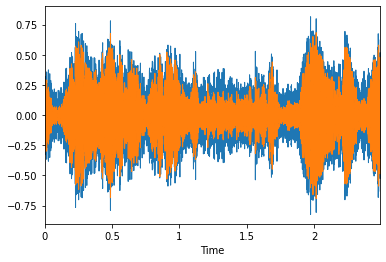

In [200]:
librosa.display.waveplot(np.squeeze(get_audio(test_sounds[1]).numpy(),-1))
librosa.display.waveplot(predict_tflite(test_sounds[1]).numpy())